In [ ]:
import pandas as pd
popular_product = pd.read_csv("Xbox_review.csv", sep='\t')

In [ ]:
popular_product["overall"] = popular_product["overall"].astype(int)
pos_reviews = popular_product[popular_product["overall"] >= 4]
neg_reviews = popular_product[popular_product["overall"] <= 2]

pos_reviews.index = range(0,len(pos_reviews))
neg_reviews.index = range(0,len(neg_reviews))

In [34]:
import numpy as np
import re
import nltk
import string

from nltk.tokenize.punkt import PunktSentenceTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


#from nltk.tag import StanfordPOSTagger
#pos_tagger = StanfordPOSTagger('/Users/bnichols/Downloads/stanford-postagger-full-2015-12-09/models/english-left3words-distsim.tagger', '/Users/bnichols/Downloads/stanford-postagger-full-2015-12-09/stanford-postagger.jar') 

def tag_words(document):
    sentence_tokenizer = PunktSentenceTokenizer()
    sentences = sentence_tokenizer.tokenize(document)
    sentences = [nltk.word_tokenize(sent) for sent in sentences]
    tagged_words = nltk.pos_tag_sents(sentences)
#    tagged_words = [st.tag(sent) for sent in sentences]    
    return tagged_words

def select_nouns(tagged_words,good_tags=set(['NN','NNP','NNS','NNPS'])):
    nouns =[]
    punct = set(string.punctuation)
    stop_words = set(nltk.corpus.stopwords.words('english'))
    for sentence in tagged_words:
        nouns +=([word.lower() for word, tag in sentence 
                        if tag in good_tags and word.lower() not in stop_words and not all(char in punct for char in word)])
    return nouns

def select_adjectives(tagged_words,good_tags=set(['JJ','JJR','JJS'])):
    adjectives =[]
    punct = set(string.punctuation)
    stop_words = set(nltk.corpus.stopwords.words('english'))
    for sentence in tagged_words:
        adjectives +=([word.lower() for word, tag in sentence 
                        if tag in good_tags and word.lower() not in stop_words and not all(char in punct for char in word)])
    return adjectives

def get_word_freq(words):
    vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 1000, ngram_range=(1,3)) 
    
    word_features = vectorizer.fit_transform(words)
    word_features = word_features.toarray()
    
    vocab = vectorizer.get_feature_names()
    
    dist = np.sum(word_features, axis=0)

    word_freq = {'count': dist, 'vocab': vocab}
    word_freq = pd.DataFrame(word_freq)
    word_freq = word_freq.sort_values(by="count",ascending=False)
    return word_freq

In [35]:
def get_sentiment_POS(POS,sentiment):
    if sentiment == "positive":
        #tag words in positive reviews (nb. pos stands for positive, POS for part of speech)
        pos_tagged_words = []
        for i in range(0,len(pos_reviews)):
            pos_tagged_words += tag_words(pos_reviews["reviewText"][i])
        
        if POS == "nouns":
            #select nouns
            pos_nouns_only = select_nouns(pos_tagged_words)
            #get word frequency
            return pos_nouns_only
        
        elif POS == "adjectives":
            #select adjectives
            pos_adjectives_only = select_nouns(pos_tagged_words)
            #get word frequency
            return pos_adjectives_only
        
        else:
            print("Error: Invalid POS option, try noun or adjective")

    elif sentiment == "negative":
        #tag words in negative reviews
        neg_tagged_words = []
        for i in range(0,len(neg_reviews)):
            neg_tagged_words += tag_words(neg_reviews["reviewText"][i])
            
        if POS == "nouns":
            #select nouns
            neg_nouns_only = select_nouns(neg_tagged_words)
            #get word frequency
            return neg_nouns_only
        
        elif POS == "adjectives":
            #select adjectives
            neg_adjectives_only = select_nouns(neg_tagged_words)
            #get word frequency
            return neg_adjectives_only
        
        else:
            print("Error: Invalid POS option, try nouns or adjectives")
    else:
        print("Error: Invalid sentiment option, try positive or negative")

In [36]:
sent_POS = get_sentiment_POS("nouns", "negative")
sent_freq = get_word_freq(sent_POS)

In [38]:
sent.head(20)

,count,vocab
976,284,xbox
112,121,console
367,108,microsoft
262,105,games
199,105,drive
530,76,ps3
258,69,game
784,69,system
376,57,money
831,46,time


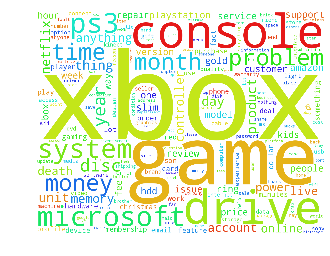

In [37]:
all_sent_words = " ".join(sent_POS)

import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

wordcloud = WordCloud(
                      background_color='white',
                      width=1800,
                      height=1400
                     ).generate(all_sent_words)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()
